In [1]:
import time
import os
import json
import random

import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import f1_score

from collections import defaultdict
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.2)

from IPython.display import clear_output

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Загрузим датасет

В предыдущем ноутбуке была проведена работа по базовому препроцессингу, получилось убрать тренд из рядов, насколько это было возможно с помощью базовых инструментов.  
При построении [датасета](https://www.kaggle.com/cdeotte/data-without-drift) была проведена похожая работа, и испробованы другие способы, в итоге лучшую из обработок выложили в открытые данные.  
Будем использовать этот датасет для дальнейшего построения моделей.

In [3]:
with open('kaggle.json', 'r') as kaggle:
    kaggle_info = json.load(kaggle)
    os.environ['KAGGLE_USERNAME'] = kaggle_info['username']
    os.environ['KAGGLE_KEY'] = kaggle_info['key']

!kaggle datasets download -d cdeotte/data-without-drift
!kaggle competitions download -c liverpool-ion-switching
!unzip -q data-without-drift.zip
!unzip -q train.csv.zip
!unzip -q test.csv.zip
!unzip -q sample_submission.csv.zip

 87% 48.0M/55.0M [00:00<00:00, 107MB/s] 
100% 55.0M/55.0M [00:00<00:00, 124MB/s]
 81% 8.00M/9.91M [00:00<00:00, 82.0MB/s]
100% 9.91M/9.91M [00:00<00:00, 61.8MB/s]
  0% 0.00/4.27M [00:00<?, ?B/s]
100% 4.27M/4.27M [00:00<00:00, 69.7MB/s]
 53% 14.0M/26.6M [00:00<00:00, 142MB/s]
100% 26.6M/26.6M [00:00<00:00, 128MB/s]


In [0]:
train_val = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [0]:
test['open_channels'] = 0

In [5]:
train_val.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


Посмотрим на то, сколько бывает открытых каналов вообще

In [6]:
print('Уникальных каналов бывает: {}'.format(np.unique(train_val['open_channels'])))

Уникальных каналов бывает: [ 0  1  2  3  4  5  6  7  8  9 10]


In [0]:
TRAIN_VAL_DATA_SIZE = len(train_val)
TEST_DATA_SIZE = len(test)

Получается, что по сути мы решаем задачу классификации на `11` классов.

In [8]:
device_num = 0
torch.cuda.set_device(device_num)
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"
print("Training on {}".format(device))

Training on cuda:0


### Почему нейронные сети?

Посмотрев на обсуждения участников соревнования, очень многие говорят о том, что в этом соревновании наилучшим образом себя показывают именно нейронные сети.  
Будем двигаться от более легкой модели к более сложной.

#### Немного работы с данными

Если подавать `RNN` на вход последовательности длины `500000` (это длина одного временного ряда), будет грустно обучать модель по времени, учитывая, что обработка все цепочки никак не параллелится.  
А так же, в самом начале обучения, когда веса определены рандомом, при прохождении всей цепочки длины 
Поэтому разделим `train` и `test` на минибатчи по `500` элементов.

In [0]:
class BasicIonDataset(Dataset):
    '''
    Базовый датасет для более удобной работы с данными
    '''
    def __init__(self, ion_signal, ion_open_channels, seq_len):
        # иначе бы на reshape получили ошибку
        assert(len(ion_signal) % seq_len == 0)

        # получается, что один элемент -- последовательность
        # длины 500, состоящая из вектора размера 1
        self.signal = ion_signal.reshape(-1, seq_len, 1)
        self.channels = ion_open_channels.reshape(-1, seq_len, 1)

    def __len__(self):
        # для корректного итерирования
        return self.signal.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = torch.FloatTensor(self.signal[idx])
        Y = torch.FloatTensor(self.channels[idx])

        return X, Y

Разделим данные на `train`, `val`, `test` и создадим для них `Dataset` и `DataLoader`

In [0]:
# длина последовательности
seq_len = 500
# количество последовательностей длины выше
num_of_seq = TRAIN_VAL_DATA_SIZE // seq_len
# индексы последовательностей, которые включаем в train
train_idx = np.random.choice(np.arange(0, num_of_seq), int(num_of_seq * 0.7), replace=False)

In [11]:
train_dataset = BasicIonDataset(np.array(train_val['signal'][(train_val.index // seq_len).isin(train_idx)]), 
                                np.array(train_val['open_channels'][(train_val.index // seq_len).isin(train_idx)]), 
                                seq_len)

val_dataset = BasicIonDataset(np.array(train_val['signal'][~(train_val.index // seq_len).isin(train_idx)]), 
                              np.array(train_val['open_channels'][~(train_val.index // seq_len).isin(train_idx)]), 
                              seq_len)

test_dataset = BasicIonDataset(np.array(test['signal']), 
                               np.array(test['open_channels']), 
                               seq_len)

print('Последовательностей в train : {}'.format(len(train_dataset)))
print('Последовательностей в val : {}'.format(len(val_dataset)))
print('Последовательностей в test : {}'.format(len(test_dataset)))

Последовательностей в train : 7000
Последовательностей в val : 3000
Последовательностей в test : 4000


In [0]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Функции для тренировки сети

In [0]:
def create_model_info_dict(model, optimizer, scheduler, tr_losses, val_losses, 
                           train_f1, val_f1, prev_info_dict=None, ):
    
    lr = 0
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        break

    if prev_info_dict is None:
        info_dict = {'lr_history' : [lr, ],
                     'model_dict' : model.state_dict(),
                     'scheduler_dict' : scheduler.state_dict(),
                     'optimizer' : optimizer.__class__.__name__,
                     'train_loss_history' : tr_losses, 
                     'val_loss_history' : val_losses, 
                     'train_f1_history' : train_f1, 
                     'val_f1_history' : val_f1}
        return info_dict
    else:
        info_dict = prev_info_dict.copy()
        info_dict['lr_history'] += [lr, ]
        info_dict['model_dict'] = model.state_dict()
        info_dict['scheduler_dict'] = scheduler.state_dict()
        info_dict['train_loss_history'] = tr_losses
        info_dict['val_loss_history'] = val_losses
        info_dict['train_f1_history'] = train_f1
        info_dict['val_f1_history'] = val_f1
        return info_dict

In [0]:
def plot_learning_curves(history, ylim):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        f1 и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()
    plt.ylim(ylim)

    plt.subplot(1,2,2)
    plt.title('Macro F1', fontsize=15)
    plt.plot(history['f1']['train'], label='train')
    plt.plot(history['f1']['val'], label='val')
    plt.ylabel('Метрика', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [0]:
def predict(model, dataloader):
    '''
    Предсказывает корректно, только если shuffle=false
    '''
    preds = []
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        logits = model(X_batch, y_batch).reshape(-1, 11)
        y_pred = logits.max(1)[1].detach().cpu().numpy()
        preds += list(y_pred)
    return preds

In [0]:
def eval_epoch(model, batch_gen, is_train=False):
    '''
    Одна эпоха обучения/валидации
    '''

    # переменные для хранения loss и метрики
    epoch_loss = 0
    epoch_f1 = 0

    model.train(is_train)

    # проходим все данные
    for X_batch, y_batch in tqdm(batch_gen):

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch, y_batch).reshape(-1, 11)
        
        y_batch = y_batch.to(device).reshape(-1)
        loss = criterion(logits, y_batch.long())

        # если обучаем -- обновляем параметры сети
        if is_train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss += np.sum(loss.detach().cpu().numpy())
        y_pred = logits.max(1)[1].detach().cpu().numpy()
        epoch_f1 += f1_score(y_batch.cpu().numpy(), y_pred, average='macro')
    
    epoch_loss /= len(batch_gen)
    epoch_f1 /= len(batch_gen) 

    return epoch_loss, epoch_f1

In [0]:
def train(
    model, 
    criterion,
    optimizer, 
    scheduler,
    sch_type,
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
    loss_lim_im=(0, 0.3),
    path_to_save=None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) f1 и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    # изначально
    info_dict = None
    
    best_val_loss = np.infty
    best_val_f1 = np.infty
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_f1 = eval_epoch(model, train_batch_gen, True)
        history['loss']['train'].append(train_loss)
        history['f1']['train'].append(train_f1)

        val_loss, val_f1 = eval_epoch(model, val_batch_gen, False)
        history['loss']['val'].append(val_loss)
        history['f1']['val'].append(val_f1)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training f1: \t\t\t{:.2f} %".format(train_f1 * 100))
        print("  validation f1: \t\t\t{:.2f} %".format(val_f1 * 100))
        
        info_dict = create_model_info_dict(model, 
                                           optimizer, 
                                           scheduler, 
                                           history['loss']['train'],
                                           history['loss']['val'],
                                           history['f1']['train'],
                                           history['f1']['val'], 
                                           info_dict)
        
        if val_f1 < best_val_f1:
            best_val_f1 = val_f1
            if path_to_save != None:
                filename = '_epoch_{}_f1_{:.6f}.pth'.format(epoch, val_f1)
                torch.save(info_dict, path_to_save + filename)

        if sch_type == 'plateao':
            scheduler.step(val_loss)
        else:
            scheduler.step()
        plot_learning_curves(history, loss_lim_im)
        
    return model, history

In [0]:
def save_predictions(model, test_loader, path_to_save='submission.csv'):
    preds = predict(model, test_loader)

    result = pd.read_csv('sample_submission.csv', dtype={'time': str})

    result = pd.DataFrame({'time': result['time'].astype(str),
                                    'open_channels': preds})

    result.to_csv(path_to_save, index=False)

### RNN

Очевидно, что значение сигнала и количество открытых каналов в момент времени `t` зависит от предыдущих значений этих признаков.  
В случае, когда данные зависят от предыдущих, как `baseline` решения с помощью нейросетей можно принимать результат, полученный с помощью рекурентной нейронной сети (`RNN`), точнее ее улучшенных версий, в которых градиент затухает медленней (`LSTM`, `GRU`)  
Реализуем базовую модель.

#### Напишем архитектуру нашей сети

Краткий план:  
- одна фича, как в нашем случае, это мало, лучше увеличить количество фичей с помощью линейного слоя
- после применения линейного слоя к полученным данным применяем `GRU`
- все-таки у нас не совсем временной ряд, в постановке задачи соревнования `Ion` не сказано, что запрещено пользоваться данными с большим временем, поэтому можно использовать `Bidirection GRU`
- после применения `GRU` к выходу каждого элемента применим линейный слой, чтобы перевести выход в пространство размерности количества классов
- считаем `loss` по всем выходам последовательности, в данном случае -- `Cross-Entropy`

In [0]:
class SimpleGRU(nn.Module):
    def __init__(self, in_features=1, n_layers=2, hid_size=512, inp_size=1000, n_classes=11):
        super(SimpleGRU, self).__init__()

        self.n_classes = n_classes
        self.inp_size = inp_size
        self.hid_size = hid_size
        self.in_features = in_features
        
        self.input_fc = nn.Linear(in_features, inp_size)
        self.rnn = nn.GRU(inp_size, hid_size, n_layers, bidirectional=True, batch_first=True)
        self.output_fc = nn.Linear(hid_size * 2, n_classes)

    def forward(self, seq, trg):
        seq = self.input_fc(seq)

        output, _ = self.rnn(seq)

        output = self.output_fc(output)

        return output

Обучим `GRU` на двух слоях (по сути, второй слой обучается на выходе первого, принимая его за свой вход)

In [0]:
!mkdir '/content/gdrive/My Drive/ad/gru2layers'

Epoch 50 of 50 took 44.168s
  training loss (in-iteration): 	0.075415
  validation loss (in-iteration): 	0.082219
  training f1: 			94.06 %
  validation f1: 			93.77 %


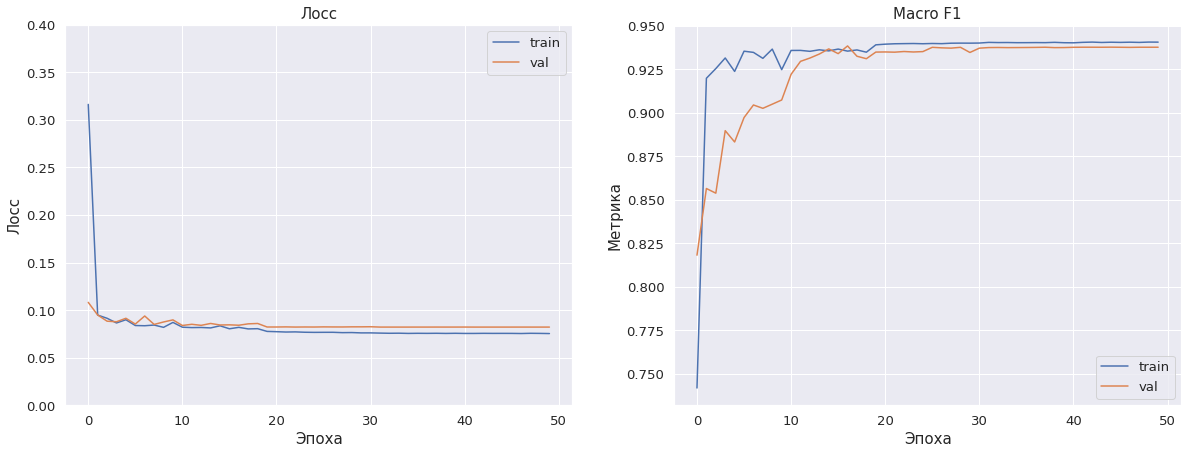

In [0]:
model = SimpleGRU().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=7, 
                                                       factor=0.1, 
                                                       min_lr=1e-8)
model, history = train(
    model, criterion, optimizer, scheduler, 'plateao',
    train_loader, val_loader, 
    num_epochs=50,
    path_to_save = '/content/gdrive/My Drive/ad/gru2layers/simplegru'
)

Мы видим, что модель вышла на плато, лосс уже практически не меняется, значения метрики тоже. В принципе, хватило бы даже 30 эпох.

Итак, наилучшая модель: 

In [0]:
print(os.listdir('/content/gdrive/My Drive/ad/gru2layers')[-1])

simplegru_epoch_34_f1_0.937521.pth


В дальнейшем ее можно будет загрузить и предсказать на `test`

С увеличем количества слоев в `GRU` усложняются возможные зависимости, которые мы можем предсказать.  
Двухслойная `GRU` справилась неплохо, а как справится трехслойная?

In [0]:
!mkdir '/content/gdrive/My Drive/ad/gru3layers'

Epoch 50 of 50 took 66.135s
  training loss (in-iteration): 	0.072550
  validation loss (in-iteration): 	0.082448
  training f1: 			94.25 %
  validation f1: 			94.73 %


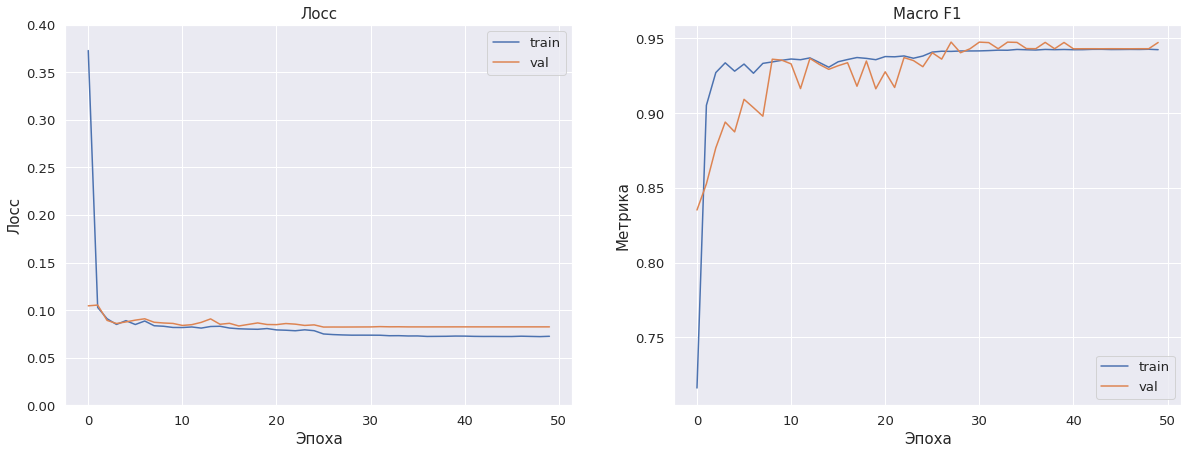

In [0]:
model = SimpleGRU(n_layers=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=7, 
                                                       factor=0.1, 
                                                       min_lr=1e-8)
model, history = train(
    model, criterion, optimizer, scheduler, 'plateao',
    train_loader, val_loader, 
    num_epochs=50,
    path_to_save = '/content/gdrive/My Drive/ad/gru3layers/simplegru'
)

По графику видно, что модель с тремся слоями справляется еще лучше

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/ad/gru3layers/best_model_0.9473.pth')

4 слоя

In [0]:
!mkdir '/content/gdrive/My Drive/ad/gru4layers'

Epoch 50 of 50 took 87.317s
  training loss (in-iteration): 	0.075287
  validation loss (in-iteration): 	0.081888
  training f1: 			94.07 %
  validation f1: 			93.60 %


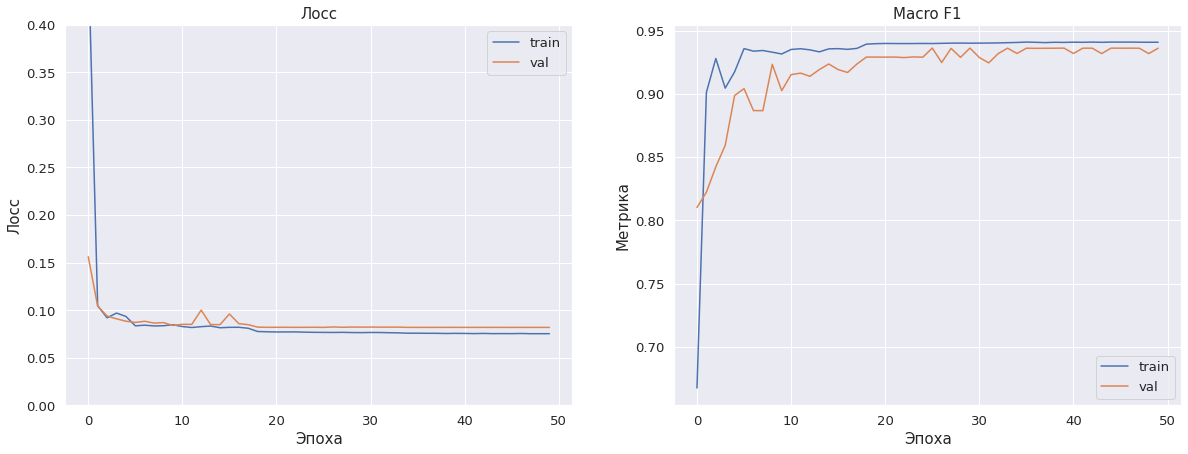

In [0]:
model = SimpleGRU(n_layers=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=7, 
                                                       factor=0.1, 
                                                       min_lr=1e-8)
model, history = train(
    model, criterion, optimizer, scheduler, 'plateao',
    train_loader, val_loader, 
    num_epochs=50,
    path_to_save = '/content/gdrive/My Drive/ad/gru4layers/simplegru'
)

С 4 слоями же сеть стала хуже, поэтому дальнейшее увеличение бессмысленно.

Отмечу, что скорее всего начальное преобразование одного признака в `inp_size` было бессмысленным, потому что в дальнейшем этот вектор будет умножаться на матрицы (без нелинейности) в самом `GRU`, а значит, линейное преобразование над линейным, результат бы почти не изменился, если бы не преобровывали одну фичу в `inp_size` фичей.

In [0]:
save_predictions(model, test_loader, 'bestgru3layers.csv')

### Seq2Seq

Архитектура `Seq2Seq` активно применяется в машинном переводе.  
Если неформально ее описывать,то модель `Seq2Seq` состоит из `Encoder` и `Decoder` частей, где 
- `Encoder` считывает исходную последовательность, сохраняя как-то информацию о ней
- `Decoder` на основе полученной информации от `Encoder` пытается получить другую последовательность  

И `Encoder`, и `Decoder` представляют из себя `RNN` (но не так давно появилась архитектура `Transformer`, позволяющая реализовать `Encoder` без рекуррентных сетей)  
Понятно, что при большой длине исходной последовательности не получится всю информацию поместить в один вектор, который будет передаваться в `Decoder`.  
Справиться с этой проблемой помогает Механизм внимания (`Attention`). Его суть в том, что при генерации последовательности мы обращает `внимание` на все выходы `encoder` с различными весами при них, а в дальнейшем на основе информации с предыдущего сгенерированного элемента последовательности и полученного представления исходного предложения, мы генерируем уже новый элемент.

![alt text](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

В рамках данной задачи, можно рассмотреть последовательность сигналов как исходную, а количество открытых каналов -- как последовательность, которую мы хотим предсказать.  
Тем самым мы получили возможность решать задачу с помощью `Seq2Seq`, насколько успешно она справится -- увидим ниже.

#### Построим Seq2Seq модель

In [0]:
def predict_seq2seq(model, dataloader):
    '''
    Предсказывает для теста
    '''
    preds = []
    for X_batch, _ in dataloader:
        X_batch = X_batch.to(device)
        logits = model.predict(X_batch).reshape(-1, 11)
        y_pred = logits.max(1)[1].detach().cpu().numpy()
        preds += list(y_pred)
    return preds

In [0]:
class Encoder(nn.Module):
    '''
    Обычный энкодер на основе RNN
    '''
    def __init__(self, hid_dim, n_layers):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(1, hid_dim, n_layers, batch_first=True)
        
    def forward(self, src):
        """
        src : (batch_size, seq_len, 1)
        """
        outputs, (hidden, cell) = self.rnn(src)
        return outputs, hidden, cell

In [0]:
class Attention(nn.Module):
    def __init__(self, hid_size, method="one-layer-net"):
        super(Attention, self).__init__()
        self.method = method
        self.hid_size = hid_size
        
        if method == 'one-layer-net':
            self.W = nn.Linear(self.hid_size, self.hid_size)
        
    def forward(self, last_hidden, encoder_outputs):
        if self.method == 'one-layer-net':
            last_hidden = self.W(last_hidden)   
        last_hidden = last_hidden.permute(0, 2, 1)

        # last_hidden : (batch_size, hid_size, 1)
        # encoder_outputs : (batch_size, seq_len, hid_size)
        weights = torch.bmm(encoder_outputs, last_hidden).squeeze(2)

        # получаем веса для каждого из скрытых слоев
        weights = F.softmax(weights, 1)
        return weights

In [0]:
class DecoderAttn(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, attention):
        super(DecoderAttn, self).__init__()
        
        self.hid_dim = hid_dim
        self.output_dim =  output_dim # число классов, в нашем случае 11
        self.n_layers = n_layers
        
        self.attn = attention
        
        self.rnn = nn.LSTM(1, self.hid_dim, self.n_layers)
        self.out = nn.Linear(self.hid_dim * 2, self.output_dim)
        
    def forward(self, input_, hidden, cell, encoder_output):
        # input -- предыдущий элементы последовательности
                
        input_ = input_.unsqueeze(0)
        output, (hidden, cell) = self.rnn(input_, (hidden, cell))

        output = output.permute(1, 0, 2)
        weights = self.attn(output, encoder_output)

        # получаем единый вектор, описывающий то, что прочитали в encoder
        attention = torch.bmm(weights.unsqueeze(1), encoder_output)

        # вектор, описывающий состояние в данный момент времени
        output = torch.cat((output, attention), -1)
        prediction = self.out(output.squeeze(1))
        
        return prediction, hidden, cell

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        # Hidden dimensions of encoder and decoder must be equal
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        """
        src : (batch_size, seq_len, 1)
        trg : (batch_size, seq_len, 1)
        teacher_forcing_ration : вероятность того, что передастся истинный прошлый таргет
        """
        batch_size = trg.shape[0]
        seq_len = trg.shape[1]
        # "алфавит" выходного языка состоит из 11 значений
        unique_trg_size = self.decoder.output_dim
        
        # тут храним выходы декодера
        outputs = torch.zeros(batch_size, seq_len, unique_trg_size).to(self.device)
        
        # начальные состоянии для начала работы декодера -- выход энкодера
        enc_out, hidden, cell = self.encoder(src)

        # берем предыдущий таргет, изначально 0
        input_ = torch.zeros((batch_size, 1)).to(self.device)

        # от 0 до max_len, т.к. получившаяся последовательность должна быть длины исходной
        for t in range(0, seq_len):
            
            output, hidden, cell = self.decoder(input_, hidden, cell, enc_out)
            # output : (batch_size, unique_trg_size)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio

            predicted_trg = output.max(1)[1]
            predicted_trg = predicted_trg.unsqueeze(1).float()

            input_ = (trg[:, t] if teacher_force else predicted_trg)
        
        return outputs

    def predict(self, src):
        '''
        Предсказывает для теста
        '''
        batch_size = src.shape[0]
        seq_len = src.shape[1]
        unique_trg_size = self.decoder.output_dim
        
        # тут храним выходы декодера
        outputs = torch.zeros(batch_size, seq_len, unique_trg_size).to(self.device)

        enc_out, hidden, cell = self.encoder(src)
        
        # берем предыдущий таргет, изначально 0
        input_ = torch.zeros((batch_size, 1)).to(self.device)

        for t in range(0, seq_len):
            
            output, hidden, cell = self.decoder(input_, hidden, cell, enc_out)

            predicted_trg = output.max(1)[1]
            predicted_trg = predicted_trg.unsqueeze(1).float()
            outputs[:, t, :] = output
            input_ = predicted_trg
        
        return outputs

In [0]:
# !mkdir '/content/gdrive/My Drive/ad/seq2seq'

In [0]:
hidden_dim = 50
n_classes = 11
n_layers = 1

enc = Encoder(hidden_dim, 1)
attention = Attention(hidden_dim)
dec = DecoderAttn(n_classes, hidden_dim, n_layers, attention)
model = Seq2Seq(enc, dec, device).to(device)

Epoch 10 of 10 took 218.702s
  training loss (in-iteration): 	0.761083
  validation loss (in-iteration): 	0.757454
  training f1: 			48.88 %
  validation f1: 			55.49 %


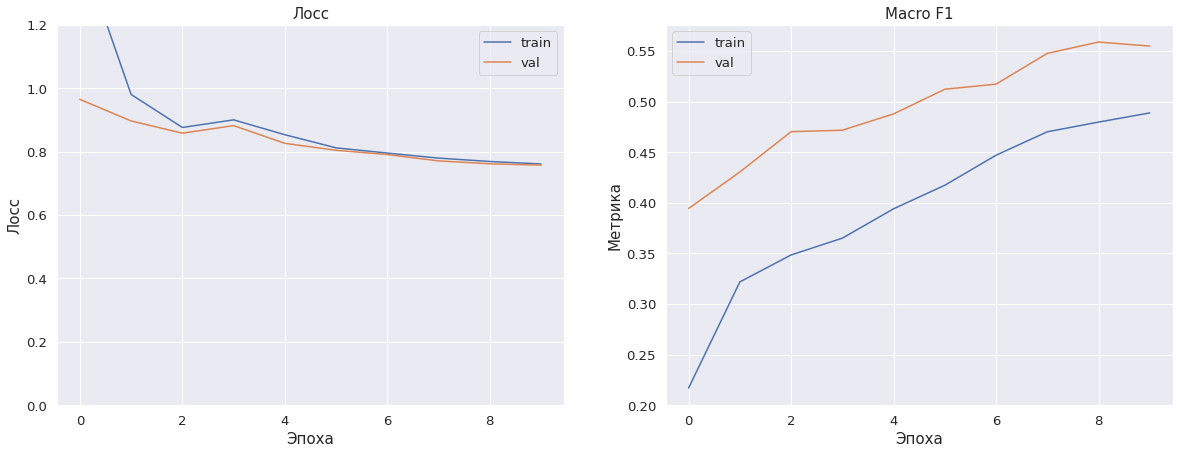

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=3, 
                                                       factor=0.1, 
                                                       min_lr=1e-8)
model, history = train(
    model, criterion, optimizer, scheduler, 'plateao',
    train_loader, val_loader, 
    num_epochs=10,
    loss_lim_im=(0, 1.2),
    path_to_save = '/content/gdrive/My Drive/ad/seq2seq/simpleseq2seq'
)

Результаты трудно назвать хорошими.  
Вполне возможно, это следствие того, что модель все-таки не совсем подходит под данную задачу, изначально она рассматривалась все-таки для машинного перевода.  
По графикам видно, что лосс скорее всего не сойдется к значению меньгему, чем 0.6.


### Что еще можно сделать?

В данный момент в нашем датасете только одна фича, но что если добавить признак, в который включить значение среднего сигнала в окрестности значения ряда?  
Это должно дать модели больше информации о том, насколько сильно сигнал в данный момент времени отличается от нормы.  
Создадим новый признак и обучим `RNN` снова.

#### Работает с признаками и создаем Dataloader

In [0]:
def add_mean_feature(data, r):
    '''
    Функция для быстрого вычисления среднего в окне радиуса r
    '''
    means = []
    
    # это разные ряды
    for i in tqdm(range(len(data) // 500000)):
        signal_part = data.loc[range(i * 500000, (i + 1) * 500000)]['signal']
        sums = np.array(np.cumsum(signal_part))

        rolling_mean = (sums[2 * r:] - sums[:-2 * r]) / (2 * r)

        # левый краевой случай
        for k in range(r):
            means.append(np.mean(signal_part.loc[range(500000 * i, 
                                                       500000 * i + k + r)]))

        means = means + list(rolling_mean)

        # правый краевой случай
        for k in range(r):
            means.append(np.mean(signal_part.loc[range(500000 * (i + 1) - r - k, 
            500000 * (i + 1))]))

    new_data = data.copy()
    new_data['mean'] = means
    return new_data

In [118]:
train_val_new = add_mean_feature(train_val, 10)
test_new = add_mean_feature(test, 10)

In [0]:
class IonMeanDataset(Dataset):
    '''
    Базовый датасет для более удобной работы с данными
    '''
    def __init__(self, ion_signal, ion_open_channels, ion_mean, seq_len):
        # иначе бы на reshape получили ошибку
        assert(len(ion_signal) % seq_len == 0)

        # получается, что один элемент -- последовательность
        # длины 500, состоящая из вектора размера 1
        self.signal = ion_signal.reshape(-1, seq_len, 1)
        self.channels = ion_open_channels.reshape(-1, seq_len, 1)
        self.mean = ion_mean.reshape(-1, seq_len, 1)

    def __len__(self):
        # для корректного итерирования
        return self.signal.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X1 = torch.FloatTensor(self.signal[idx])
        X2 = torch.FloatTensor(self.mean[idx])
        X = torch.cat((X1, X2), dim=-1)
        Y = torch.FloatTensor(self.channels[idx])

        return X, Y

In [0]:
# длина последовательности
seq_len = 500
# количество последовательностей длины выше
num_of_seq = TRAIN_VAL_DATA_SIZE // seq_len
# индексы последовательностей, которые включаем в train
train_idx = np.random.choice(np.arange(0, num_of_seq), int(num_of_seq * 0.7), replace=False)

In [170]:
train_dataset_new = IonMeanDataset(np.array(train_val_new['signal'][(train_val.index // seq_len).isin(train_idx)]), 
                                   np.array(train_val_new['open_channels'][(train_val.index // seq_len).isin(train_idx)]),
                                   np.array(train_val_new['mean'][(train_val.index // seq_len).isin(train_idx)]),
                                   seq_len)

val_dataset_new = IonMeanDataset(np.array(train_val_new['signal'][~(train_val.index // seq_len).isin(train_idx)]), 
                                 np.array(train_val_new['open_channels'][~(train_val.index // seq_len).isin(train_idx)]),
                                 np.array(train_val_new['mean'][~(train_val.index // seq_len).isin(train_idx)]),
                                 seq_len)

test_dataset_new = IonMeanDataset(np.array(test_new['signal']), 
                                  np.array(test_new['open_channels']), 
                                  np.array(test_new['mean']), 
                                  seq_len)

print('Последовательностей в train : {}'.format(len(train_dataset_new)))
print('Последовательностей в val : {}'.format(len(val_dataset_new)))
print('Последовательностей в test : {}'.format(len(test_dataset_new)))

Последовательностей в train : 7000
Последовательностей в val : 3000
Последовательностей в test : 4000


In [0]:
batch_size = 64

train_loader_new = DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
val_loader_new = DataLoader(val_dataset_new, batch_size=batch_size, shuffle=False)
test_loader_new = DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False)

#### Обучим GRU

In [173]:
# !mkdir '/content/gdrive/My Drive/ad/gru3layerswithmean/'

mkdir: cannot create directory ‘/content/gdrive/My Drive/ad/gru3layerswithmean/’: File exists


Epoch 20 of 20 took 213.461s
  training loss (in-iteration): 	0.083628
  validation loss (in-iteration): 	0.081380
  training f1: 			93.74 %
  validation f1: 			91.41 %


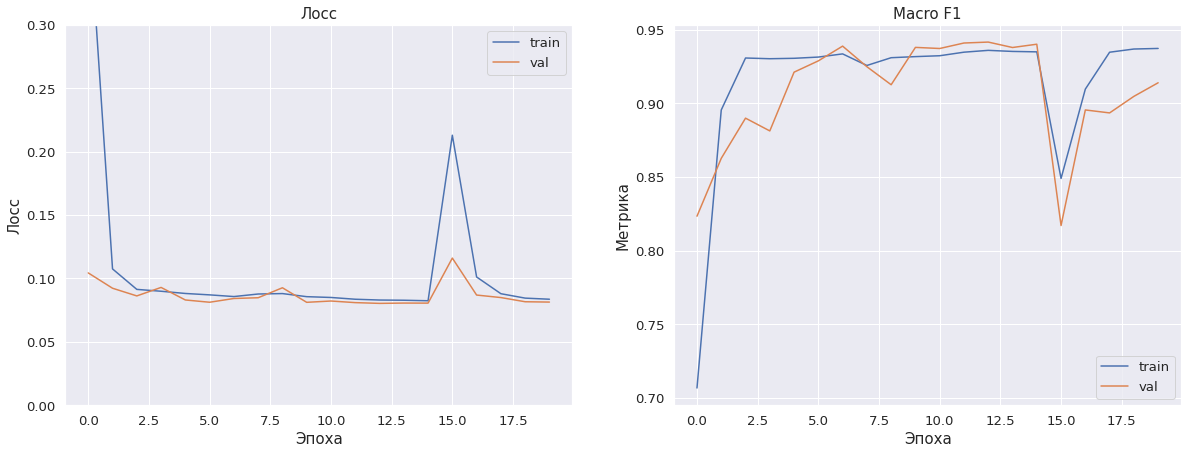

In [175]:
model = SimpleGRU(in_features=2, n_layers=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=4, 
                                                       factor=0.1, 
                                                       min_lr=1e-8)
model, history = train(
    model, criterion, optimizer, scheduler, 'plateao',
    train_loader_new, val_loader_new, 
    num_epochs=20,
    path_to_save = '/content/gdrive/My Drive/ad/gru3layerswithmean/simplegru'
)

Как видно по графику, по метрике `f1` модель оказалась хуже `RNN` без признака.  
Однако, эта модель обучалась 20 эпох вместо 50, а значение метрики на данном этапе у нее лучше.  
Поэтому у подобной модели есть потенциал, и нужно побробовать дообучить ее, или же вообще подумать, какие еще фичи можно добавить.